In [3]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

# upload file and load dataset
def upload_file(file_path='mmr.xlsx', sheet_name='car_sale'):
    file=pd.ExcelFile(file_path)
    print(file.sheet_names)
    df=pd.read_excel(file_path, sheet_name=sheet_name)# load dataset
    return df

# initialize and run prediction model (train set:80%, test set:20%) 
def predict_mmr(df):
    # encode features for training
    mileage_map={'0-5k':1, '5k-50k':2, '50k-100k':3, '100k-150k':4, '150k-200k':5, '200k-250k':6, '250k-500k':7, '>500k':8} # use ordinal encoding for mileage
    df['mileage_bin']=df['mileage'].map(mileage_map)
    quality_map={'0-.4':1, '.4-.8':2, '.8-1.2':3, '1.2-1.6':4, '1.6-2':5} # use ordinal encoding for quality rating
    df['quality_bin']=df['quality rating'].map(quality_map)
    df['model_encoded']=df['model'].map(df['model'].value_counts()) # use frequency encoding for models
    df=pd.get_dummies(df, columns=['brand category', 'body', 'color', 'state'], drop_first=True) # use one hot encoding for other features
    features=['mmr', 'quality_bin', 'mileage_bin', 'model_encoded', 'risk score'] + [col for col in df.columns if col.startswith('brand category_') or col.startswith('body_') or col.startswith('color_') or col.startswith('state_')]
    #'mmr' is an input feature used to predict mmr2
    
    # initiate the XGBRegressor model, train and predict on test set (20% of dataset)
    x=df[features]
    y=df['mmr2']
    x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
    model_mmr = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
    model_mmr.fit(x_train_val, y_train_val)
    y_pred_test = model_mmr.predict(x_test)

    # Find the improvement in mmr, after prediction  
    x_test_copy = x_test.copy()
    x_test_copy['mmr2_pred'] = y_pred_test
    x_test_copy['mmr'] = df.loc[x_test_copy.index, 'mmr'] # Make sure index alignment is correct
    x_test_copy['sellingprice'] = df.loc[x_test_copy.index, 'sellingprice']
    x_test_copy['old_flag'] = x_test_copy['mmr'] > x_test_copy['sellingprice'] # Compare old vs new flags on test set
    x_test_copy['new_flag'] = x_test_copy['mmr2_pred'] > x_test_copy['sellingprice']
    old_overpriced = x_test_copy['old_flag'].sum()
    new_overpriced = x_test_copy['new_flag'].sum()
    improvement = old_overpriced - new_overpriced
    print(f"[TEST SET] Old MMR > Sale Price: {old_overpriced} cases") # print results
    print(f"[TEST SET] New MMR2 > Sale Price: {new_overpriced} cases")
    print(f"[TEST SET] Improved in {improvement} cases ({improvement / old_overpriced:.2%})")

    # plot the count of 'mmr > sellingprice' cases
    plt.bar(['Old MMR > Sale Price', 'New MMR2 > Sale Price'],
            [old_overpriced, new_overpriced],
            color=['blue', 'orange'])
    plt.ylabel('Number of Vehicles')
    plt.title('Test Set: Overpriced MMR Comparison')
    plt.tight_layout()
    plt.show()

    # find the improvement in deviation (sellingprice - mmr), after prediction
    x_test_copy['deviation_old'] = x_test_copy['sellingprice'] - x_test_copy['mmr']
    x_test_copy['deviation_new'] = x_test_copy['sellingprice'] - x_test_copy['mmr2_pred']
    avg_deviation_old = x_test_copy['deviation_old'].mean()
    avg_deviation_new = x_test_copy['deviation_new'].mean()
    print(f"Average Deviation (Test Set):") # print results
    print(f"Old: Avg.(sellingprice - mmr) = {avg_deviation_old:,.2f}")
    print(f"New: Avg.(sellingprice - mmr2_pred) = {avg_deviation_new:,.2f}")
    return df, model_mmr, features

    # find MAE, RMSE and R-square
    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    print(f"MAE:  {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R²:   {r2:.4f}")
    return df, model_mmr, features

# plot SHAP summary
def mmr_shap(df, model_mmr, features):
    sample_df = df.sample(n=300, random_state=42)
    x_sample = sample_df[features]
    explainer = shap.TreeExplainer(model_mmr.get_booster())
    shap_values = explainer.shap_values(x_sample)
    shap.summary_plot(shap_values, x_sample)
    
    # plot SHAP values of individual feature
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values[0], x_sample.iloc[0])
    shap.dependence_plot("risk score", shap_values, x_sample)

In [21]:
df=upload_file()

['car_sale']


[TEST SET] Old MMR > Sale Price: 54340 cases
[TEST SET] New MMR2 > Sale Price: 31504 cases
[TEST SET] Improved in 22836 cases (42.02%)


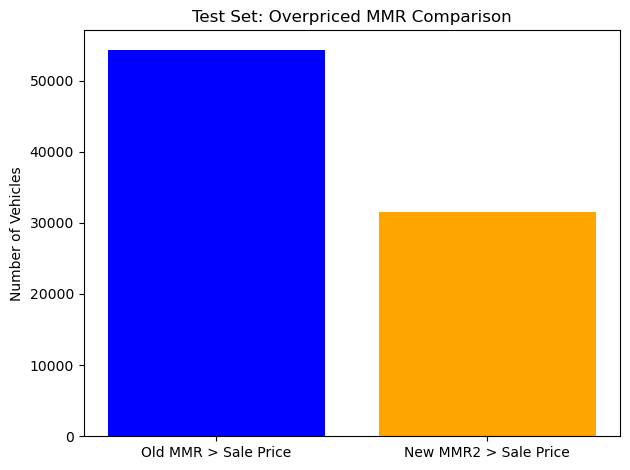

📊 Average Deviation (Test Set):
Old: Avg.(sellingprice - mmr) = -153.09
New: Avg.(sellingprice - mmr2_pred) = 634.97


In [23]:
df, model_mmr, features = predict_mmr(df)

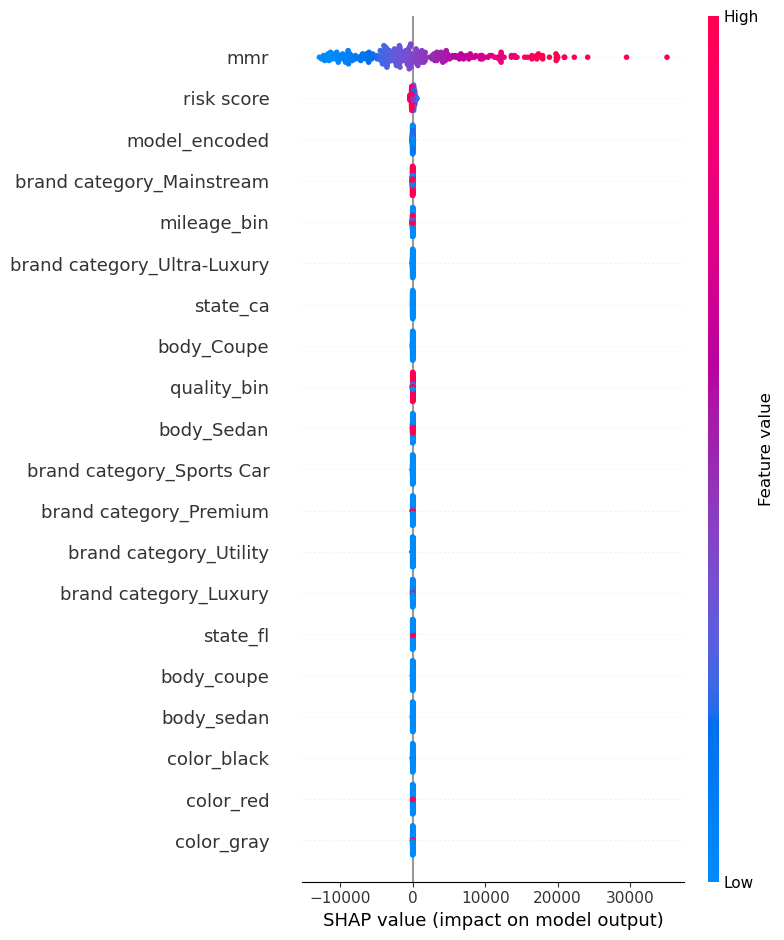

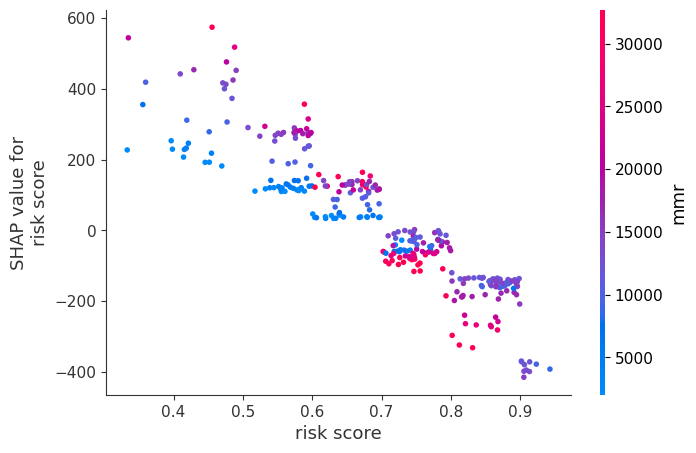

In [10]:
mmr_shap(df, model_mmr, features)